## Use phot-griz environment (updated photutils)

In [1]:
# General imports
import os
import numpy as np
import matplotlib.pyplot as plt

# Segmentation
from astropy.io import fits
from photutils.segmentation import SourceFinder, make_2dgaussian_kernel, SourceCatalog
from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve

# grizli
from grizli.model import GrismFLT
import grizli

os.chdir("/Users/keith/astr/research_astr/summer-roman-project/4) FOV0_sims/fits")
root = "GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits"
direct_file = "ready_direct_{0}".format(root)
seg_file = "seg_{0}".format(root)

In [2]:
# Process direct image and produce segmentation map

# Open image
direct_fits = fits.open(direct_file)
data, header = (direct_fits[1].data, direct_fits[1].header)
direct_fits.close()

# Subtract background
bkg_estimator = MedianBackground()
bkg = Background2D(data, (511,511), filter_size=(3,3), bkg_estimator=bkg_estimator)
data -= bkg.background

# Convolve image
kernel = make_2dgaussian_kernel(3.0, 5)
convolved_data = convolve(data, kernel)

# Instantiate the SourceFinder and set threshold
finder = SourceFinder(npixels=7, nlevels=32, contrast=0.001)
threshold = 2 * bkg.background_rms

seg_map = finder(convolved_data, threshold)

# Save seg_map as fits
fits.writeto(seg_file, seg_map, header=header,overwrite=True)

Deblending:   0%|          | 0/6281 [00:00<?, ?it/s]

In [3]:
# Create Catalog
cat = SourceCatalog(data, seg_map, convolved_data=convolved_data)

# Grizli expects these columns later
cat.add_extra_property('id', np.cast[int](cat.label), overwrite=True)
cat.add_extra_property('x_flt', cat.xcentroid, overwrite=True)
cat.add_extra_property('y_flt', cat.ycentroid, overwrite=True)

# Calculate flux using a reference object (reference object info hardcoded)
mag = -2.5 * np.log10(cat.segment_flux/206.04939338564867) + 25.88 
cat.add_extra_property('mag', mag, overwrite=True)

# Convert cumbersome catalog into usable table
columns = ['id', 'x_flt', 'y_flt', 'mag']
tbl = cat.to_table(columns)

# # Uncomment to save catalog
# seg_cat = "seg_cat.detect.cat"

# if os.path.exists(seg_cat):
#             os.remove(seg_cat)
# tbl.write(seg_cat, format='ascii.commented_header')

In [4]:
# Instantiate the GrismFLT object
pad = 100
roman_sim = GrismFLT(direct_file=direct_file, seg_file=seg_file, pad=pad)
roman_sim.compute_full_model(mag_limit=28, size=77, compute_size=False)



Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation seg_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


Text(0.5, 1.0, 'Simulated Grism Image - Flat Spectra')

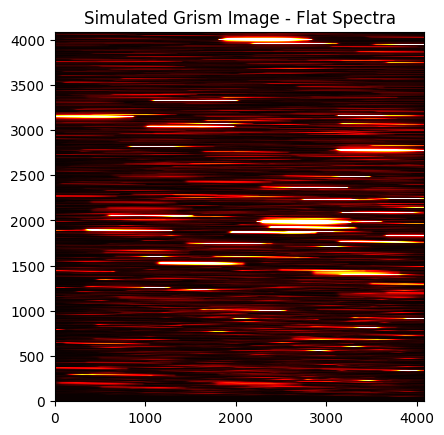

In [5]:
plt.imshow(roman_sim.model[pad:-pad, pad:-pad], vmin=0., vmax=roman_sim.model.max()/100,
           interpolation='Nearest', origin='lower', cmap='hot')

plt.title("Simulated Grism Image - Flat Spectra")

In [6]:
raise Exception("Pause before saving")

Exception: Pause before saving

In [7]:
fits.writeto("flat_spectra_{0}".format(root), roman_sim.model[pad:-pad, pad:-pad], header=header, overwrite=True)